## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

In [48]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
import torch.nn.functional as F
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import time
from random import sample


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-course/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

# with open('sonnets.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# TEXT_START = 45
# TEXT_END = -368
# text = text[TEXT_START : TEXT_END]
# assert len(text) == 2616

--2022-12-13 09:53:15--  https://raw.githubusercontent.com/girafe-ai/ml-course/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2022-12-13 09:53:15 (5.65 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [9]:
# # Join all the strings into one and lowercase it
# # Put result into variable text.

# # Your great code here
# text = ''.join(text).lower()


# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [252]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]
text = ''.join(text).lower()

--2022-12-13 16:31:29--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2022-12-13 16:31:29 (8.00 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [253]:
SOS = '<' #start of sequence token
EOF = '>' #end of sequence token
SOS in set(text) or EOF in set(text)

False

In [254]:
tokens = sorted(set(text))
tokens.append(SOS)
tokens.append(EOF)

In [255]:
tokens

['\n',
 ' ',
 '!',
 '(',
 ')',
 ',',
 '-',
 '.',
 '5',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '[',
 ']',
 '^',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '«',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '–',
 '—',
 '’',
 '…',
 '€',
 '<',
 '>']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [256]:
# dict <index>:<char>
# Your great code here
token_to_idx = {u:i for i, u in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {i:u for i, u in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [257]:
num_tokens = len(tokens)
RNN_SIZE = 256 #The number of features in the hidden state h
EMBEDDING_SIZE = 64 # The number of features in the input x/How mane features reperesent token
SEQUENCE_SIZE = 100 # Length of each sequence/Number of hidden layers
BATCH_SIZE = 64
EPOCHS = 100

In [258]:
def to_matrix(text, token_to_idx=token_to_idx, seq_size=SEQUENCE_SIZE, batch_size=BATCH_SIZE):
    """
    Casts a text into rnn-digestable matrix of shape (batch_size * num_batches) x (seq_size + 2).
    """
    char_ints = [token_to_idx[char] for char in text]
    num_batches = int(len(char_ints) / (batch_size * seq_size)) # if we don't have enough tokens for last batch, then it's delested
    matrix = np.zeros((num_batches * batch_size, seq_size + 2), dtype='int32')

    for i in range(batch_size * num_batches):
        matrix[i] = [token_to_idx[SOS]] + char_ints[i * seq_size:(i + 1) * seq_size] + [token_to_idx[EOF]]

    return matrix

In [259]:
print(to_matrix(text))

[[83  0 26 ... 64 57 84]
 [83 45 63 ... 59 63 84]
 [83 66 59 ... 60 59 84]
 ...
 [83 53  1 ... 53 57 84]
 [83  0 49 ...  1 56 84]
 [83 53 14 ... 55 45 84]]


In [260]:
assert len(text) - len(to_matrix(text, token_to_idx)) * len(to_matrix(text, token_to_idx)[0]) < BATCH_SIZE * SEQUENCE_SIZE
assert len(to_matrix(text, token_to_idx)) % BATCH_SIZE == 0

In [261]:
class VanilaRNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=EMBEDDING_SIZE, rnn_num_units=RNN_SIZE):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        h_seq, h_state = self.rnn(self.emb(x), h_prev)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h_state

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.num_units, requires_grad=True)
    
model = VanilaRNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [270]:
def train_model(model, text, loss_func=loss_func, opt=opt, is_lstm=False):
    batches = to_matrix(text)
    train_loss = []
    for epoch in range(EPOCHS):
        ep_train_loss = []
        permutation = torch.randperm(len(batches))
        start_time = time.time()

        model.train()
        if is_lstm:
            state_h, state_c = model.initial_state(BATCH_SIZE)
            state_h = state_h.to(device)
            state_c = state_c.to(device)
        else:
            hid_state = model.initial_state(BATCH_SIZE).to(device)
        for i in range(0, len(batches), BATCH_SIZE):
            batch_ind = permutation[i:i + BATCH_SIZE]
            batch = torch.tensor(batches[batch_ind], dtype=torch.int64).to(device)
            
            if is_lstm:
                logits_seq, (state_h, state_c) = model(batch, (state_h, state_c))
                state_h = state_h.detach()
                state_c = state_c.detach()
            else:
                logits_seq, hid_state = model(batch, hid_state)
                hid_state = hid_state.detach()
            # compute loss
            predictions_logits = logits_seq[:, :-1]
            actual_next_tokens = batch[:, 1:]

            loss = loss_func(
                predictions_logits.reshape((-1, num_tokens)),
                actual_next_tokens.reshape(-1)
            )
            loss.backward()

            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        train_loss.append(np.mean(ep_train_loss))
        print(f'Epoch {epoch + 1} of {EPOCHS} took {time.time() - start_time:.3f}s')
        print(f"\t  training loss: {train_loss[-1]:.6f}")
    return train_loss

In [263]:
loss = train_model(model, text)

Epoch 1 of 100 took 2.591s
	  training loss: 3.509656
Epoch 2 of 100 took 2.611s
	  training loss: 2.956570
Epoch 3 of 100 took 2.534s
	  training loss: 2.741417
Epoch 4 of 100 took 2.544s
	  training loss: 2.618251
Epoch 5 of 100 took 2.534s
	  training loss: 2.543511
Epoch 6 of 100 took 2.578s
	  training loss: 2.488120
Epoch 7 of 100 took 2.523s
	  training loss: 2.442240
Epoch 8 of 100 took 2.531s
	  training loss: 2.402827
Epoch 9 of 100 took 2.566s
	  training loss: 2.367663
Epoch 10 of 100 took 2.612s
	  training loss: 2.333281
Epoch 11 of 100 took 2.520s
	  training loss: 2.302429
Epoch 12 of 100 took 2.526s
	  training loss: 2.275947
Epoch 13 of 100 took 2.520s
	  training loss: 2.252339
Epoch 14 of 100 took 2.551s
	  training loss: 2.226297
Epoch 15 of 100 took 2.526s
	  training loss: 2.203893
Epoch 16 of 100 took 2.525s
	  training loss: 2.184013
Epoch 17 of 100 took 2.523s
	  training loss: 2.164145
Epoch 18 of 100 took 2.579s
	  training loss: 2.144219
Epoch 19 of 100 too

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [264]:
def plot_loss(loss):
    plt.figure(figsize=(15, 5))

    plt.title("Loss")
    plt.xlabel("#epoch")
    plt.ylabel("loss")
    plt.plot(loss)
    plt.grid(True)
    plt.show()

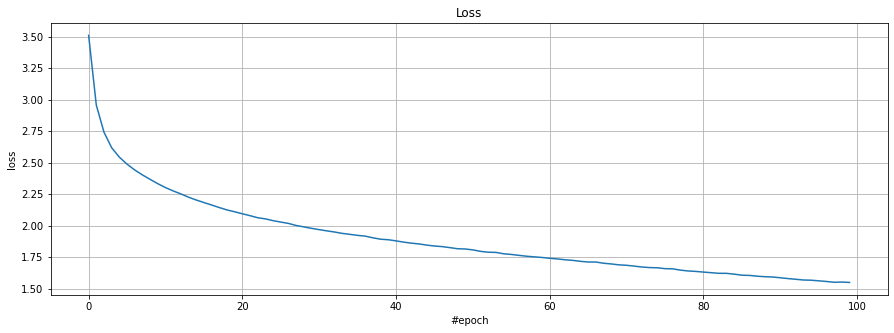

In [265]:
plot_loss(loss)

In [271]:
def generate_text(model, seed_phrase=SOS, temperature=1.0, token_to_idx=token_to_idx, idx_to_token=idx_to_token, max_length=100, is_lstm=False):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    model.eval()
    with torch.no_grad():
        x_sequence = [token_to_idx[token] for token in seed_phrase]
        if is_lstm:
            state_h, state_c = model.initial_state(1)
            state_h = state_h.to(device)
            state_c = state_c.to(device)
        else:
            hid_state = model.initial_state(1).to(device)

        #feed the seed phrase, if any
        for i in range(len(seed_phrase)):
            ix = torch.tensor([[x_sequence[i]]]).to(device)
            if is_lstm:
                logits_next, (state_h, state_c) = model(ix, (state_h, state_c))
            else:
                logits_next, hid_state = model(ix, hid_state)
        #start generating
        for _ in range(max_length - len(seed_phrase)):
            ix = torch.tensor([[x_sequence[i]]]).to(device)
            ix = torch.tensor([[x_sequence[-1]]]).to(device)
            if is_lstm:
                logits_next, (state_h, state_c) = model(ix, (state_h, state_c))
            else:
                logits_next, hid_state = model(ix, hid_state)
            # Be really careful here with the model output
            p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0][0]
            
            # sample next token and push it back into x_sequence
            next_ix = np.random.choice(len(tokens), p=p_next)
            if next_ix == token_to_idx[EOF]:
                break
            x_sequence.append(next_ix)

        
    return ''.join([idx_to_token[ix] for ix in x_sequence])

In [272]:
# An example of generated text.
print(generate_text(model, seed_phrase='любимая екатерина постойте', max_length=500, temperature=0.2))

любимая екатерина постойтет
на простительно не умела
пора долго в нем старый своей.



xxxiii

он был по небо весель


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [280]:
class LSTM(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=EMBEDDING_SIZE, rnn_num_units=RNN_SIZE):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        h_seq, h_state = self.rnn(self.emb(x), h_prev)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h_state

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.num_units, requires_grad=True), torch.zeros(1, batch_size, self.num_units, requires_grad=True)
    
model = LSTM().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [281]:
loss = train_model(model, text, is_lstm=True, opt=opt, loss_func=loss_func)

Epoch 1 of 100 took 20.504s
	  training loss: 3.738509
Epoch 2 of 100 took 12.399s
	  training loss: 3.140505
Epoch 3 of 100 took 9.701s
	  training loss: 2.911374
Epoch 4 of 100 took 8.753s
	  training loss: 2.749551
Epoch 5 of 100 took 8.935s
	  training loss: 2.648823
Epoch 6 of 100 took 8.833s
	  training loss: 2.577192
Epoch 7 of 100 took 8.804s
	  training loss: 2.520009
Epoch 8 of 100 took 8.699s
	  training loss: 2.472799
Epoch 9 of 100 took 8.781s
	  training loss: 2.429574
Epoch 10 of 100 took 8.752s
	  training loss: 2.394029
Epoch 11 of 100 took 10.367s
	  training loss: 2.362360
Epoch 12 of 100 took 8.843s
	  training loss: 2.335394
Epoch 13 of 100 took 9.539s
	  training loss: 2.311590
Epoch 14 of 100 took 8.674s
	  training loss: 2.287963
Epoch 15 of 100 took 8.654s
	  training loss: 2.268879
Epoch 16 of 100 took 8.637s
	  training loss: 2.246716
Epoch 17 of 100 took 8.731s
	  training loss: 2.227460
Epoch 18 of 100 took 8.801s
	  training loss: 2.209824
Epoch 19 of 100 

Plot the loss function of the number of epochs. Does the final loss become better?

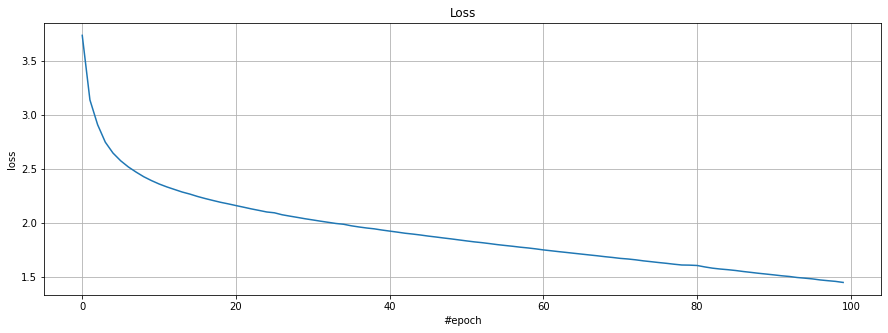

In [282]:
plot_loss(loss)

**The final loss is better, but not so significant, may be with tuned lr the difference will be large**

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [291]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperatures:
    print('#'*100)
    print('temperature: ', temperature)
    print(generate_text(model, seed_phrase='если бы я м', max_length=500, temperature=temperature, is_lstm=True))

####################################################################################################
temperature:  0.1
если бы я мой
во все девой последней того,
как он мог онегин поэта,
и в самом деревне с ним страна
и темное старины простой
и стал без молодой в долей.



xxxii

сей под ней и под венерный,
в сем не встречает на свете,
и нет на стала не своей.
она в семерью веселья стройной
старинуться возов дороги,
и после наш онегина своей
надель и вот просто она
свои простой толку волненье,
в постелет мой обедала стралось
в сем не встречает на свете,
и в сердцем полковые мечты,
не знала он был поразленный,
и 
####################################################################################################
temperature:  0.2
если бы я мел



xxvii

«муж татьяна полно, понять молодной
в своей и соседа подруга
старушка молодой послед,
и страстей и в солнце тогда
я был он простой то скука,
к мой модных девицы своей души
и вольное стали нежной.



xiii

и страшно гордость верно всех,
н

**Looks like temperatures < 0.5 provide better results, than >= 0.5. Apparently, this is because some letters have high prior probability. So, lower temperature decrease impact of prior probability**

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [287]:
torch.save(model.state_dict(), 'model')

In [288]:
model_loaded = LSTM()
model_loaded.load_state_dict(torch.load('model'))

<All keys matched successfully>

In [295]:
print(generate_text(model_loaded, seed_phrase='хочу отдохн', max_length=500, temperature=0.2, is_lstm=True))

хочу отдохной
он из волной сон возрастой
в душа в семеньем молодой,
и слезы ль


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)